In [1]:
%matplotlib inline

import glob
import os
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Modelling hydropower impacts in Nitelva (Oslo Nordmarka)

[For background information, see e-mail discussion with Asle on 06.08.2019]

We would like to estimate how hydropower infrastructure on Nitelva affects river morphology. Most of the hydro infrastructure is old (early 1900s), although much of it has been upgraded and developed over time.

The best monitoring data available to represent the current (i.e. modified) flow regime is from Fossen (NVE ID 2.461), which has an upstream catchment area of 225 km<sup>2</sup>. The natural flow regime in this watershed is primarily affected by two dams immediately upstream (Verksfossen and Sagfossen), as well as by abstraction/water transfers between the lakes of Trehørningen and Helgeren. There are also numerous other dams further upstream - see [this link](https://atlas.nve.no/Html5Viewer/index.html?viewer=nveatlas&layerTheme=null&scale=80000&basemap=&center=271063.78950149193%2C6669407.491612272&layers=3H1NK20Qc%2Bmp3Sp11M0VyC4j0VyC4j1RTtWs05u0nq3BHcOm) for an overview of the existing infrastructure.

We would like to estimate what the flow regime might look like without these dams and transfers. The easiest way to approximate this is to identify a dataset from a nearby "natural" catchment with similar characteristics to Nitelva, and then scale flows according to the ratio of catchment areas. This is pretty rough, but it should provide a starting point.


## 1. Identify candidate "natural" streams

Finding streams in the Nordmarka not affected by hydropower or drinking water infrastructure is not easy, but after a bit of searching using NVE Atlas I've identified some candidate streams - see the table below. For each of these, I've used [NEVINA](http://nevina.nve.no/) to derive catchment boundaries and summary flow statistics, which should provide useful background information for the processing that follows. I've also attempted to independently confirm NEVINA's catchment area calculations using NVE's reports and online documentation (see [here](https://www2.nve.no/h/hd/plotreal/Q/0002.00461.000/index.html) for Fossen; [here](https://vegvesen.brage.unit.no/vegvesen-xmlui/handle/11250/189768) for the others).

**Note:** Ideally, the candidate catchments should have a similar upstream area to Fossen, but without any morphological modifications. Unfortunately, I can't find any unmodified streams of this size in Nordmarka or its surroundings. All the candidtaes in the table below are therefore rather small, with few or no lakes. This means they might not be suitable for upscaling but, at present, I can't think of a better alternative given the time available.


|   station_name  | nve_id | nevina_area_km2 | nve_area_km2 | comment                                                                                                           | useful |
|:---------------:|:------:|----------------:|-------------:|-------------------------------------------------------------------------------------------------------------------|:------:|
|      Fossen     |  2-461 |           225.2 |          225 | This is the catchment of interest (Nitelva). Affected by hydropower                                               |   Yes  |
|      Vikka      |  2-590 |           20.36 |         13.1 | Tribuatry of Leira to E. Includes Gardermoen airport. NVE warns of very low quality data. Catchment area mismatch |   No   |
| Slemdalsbekken1 |  2-601 |            2.54 |          4.8 | Small catchment to E. No obvious hydro, but unstable channel profile. Catchment area mismatch                     |   No   |
|   Sinnerdammen  |  6-71  |            7.84 |         7.69 | Small catchment to W. Quite close to Nitelva                                                                      |   Yes  |
|  Saeternbekken  |   8-6  |            6.27 |         6.33 | Small catchment to SW. Low quality data since 2006                                                                |  Yes?  |
|    Langtjern    | 12-188 |            4.88 |         4.81 | Small catchment to NW. Too far away to be a useful reference?                                                     |   No?  |
|     Kuggerud    |  2-616 |           48.17 |         47.5 | Medium-sized natural catchment. Too far to the E?                                                                 |  Yes?  |

The code below reads the table of catchment areas into a dataframe for later use.

In [2]:
# Read station summary table
xl_path = r'../station_summary.xlsx'
stn_df = pd.read_excel(xl_path)

## 2. Discharge data

For each of the stations listed above, I've downloaded all available daily flow data from NVE's Hydra-II database. The code below reads the raw data, aligns it, and produces summary plots for each station.

In [3]:
# Folder of Hydra-II CSVs
search_path = r'../flow_data/*.csv'
file_list = glob.glob(search_path)

# Loop over stations
df_list = []

for fpath in file_list:
    fname = os.path.split(fpath)[1]
    nve_id = fname.split('_')[0]
    stn_name = fname.split('_')[1][:-4]
    
    # Vikka and Slemdalsbekken are not of sufficient quality to use
    if stn_name not in ('Vikka', 'Slemdalsbekken1'):
    
        df = pd.read_csv(fpath, 
                         header=None, 
                         index_col=0,
                         names=[stn_name],
                         skiprows=1,
                         na_values=-9999,
                         parse_dates=True)

        df = df.resample('D').mean()  # Strip times as not necessary

        # Strip NaN from start and end of the series
        first_idx = df.first_valid_index()
        last_idx = df.last_valid_index()
        df = df.loc[first_idx:last_idx]

        df_list.append(df)
    
# Combine
df = pd.concat(df_list, axis=1)
  
# Data from Saeternbekken from 2006 onwards is considered to be of low quality. Remove
df['Saeternbekken'][df['Saeternbekken'].index.year >= 2006] = np.nan

df.head()    

,Langtjern,Fossen,Kuggerud,Sinnerdammen,Saeternbekken
1968-04-27,NaN,NaN,3.76482,NaN,NaN
1968-04-28,NaN,NaN,3.38612,NaN,NaN
1968-04-29,NaN,NaN,3.11924,NaN,NaN
1968-04-30,NaN,NaN,2.86662,NaN,NaN
1968-05-01,NaN,NaN,2.55135,NaN,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0a8440d30>,
      dtype=object)

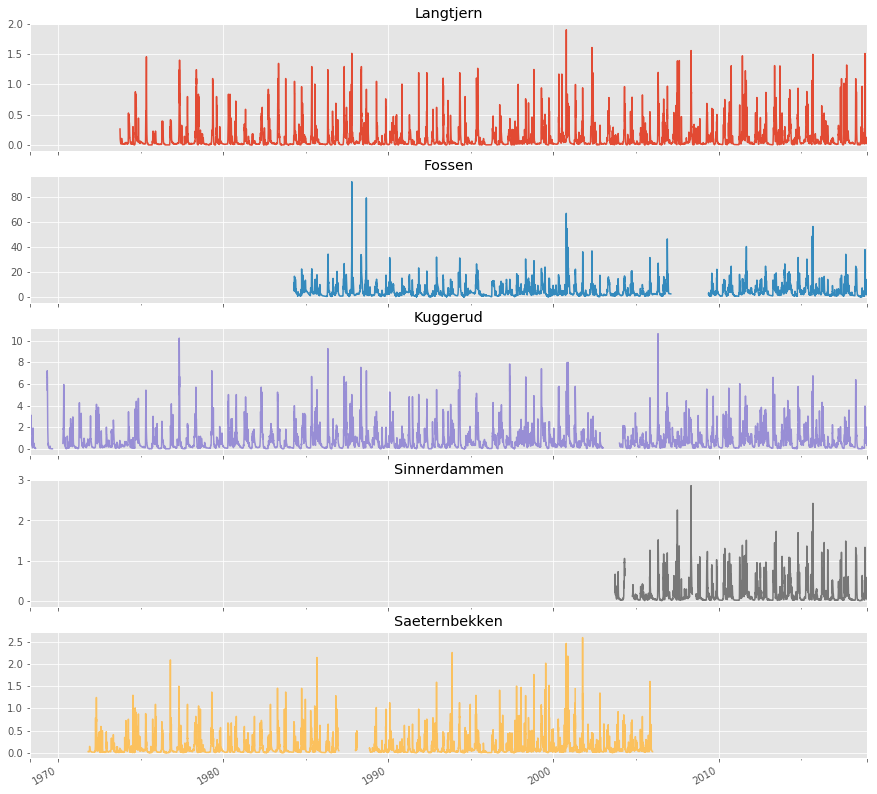

In [4]:
# Plot
df.plot(subplots=True, 
        legend=False,
        title=list(df.columns),
        figsize=(15,15))

## 3. Area-scaling

From above, there are four possible "natural" reference series for Fossen, ranging from Langtjern in the west to Kuggerud in the east. In principle, any of these could be used for estimating the natural flow regime at Fossen by area-scaling. A useful starting point is to try area-normalising all four series, and then comparing them to one another. This should give an indication of whether the general approach of area-scaling for transferring flow regimes within this broad area can be justified.

**Note:** From this point on, I will work with **monthly averaged flow series**. The catchments under consideration are geographically spread, so they will obviously receive different weather systems at different times on a day-to-day basis. My hope, however, is that they experience broadly the same weather patterns on a monthly average basis, which should be sufficient for comparing flow regimes.

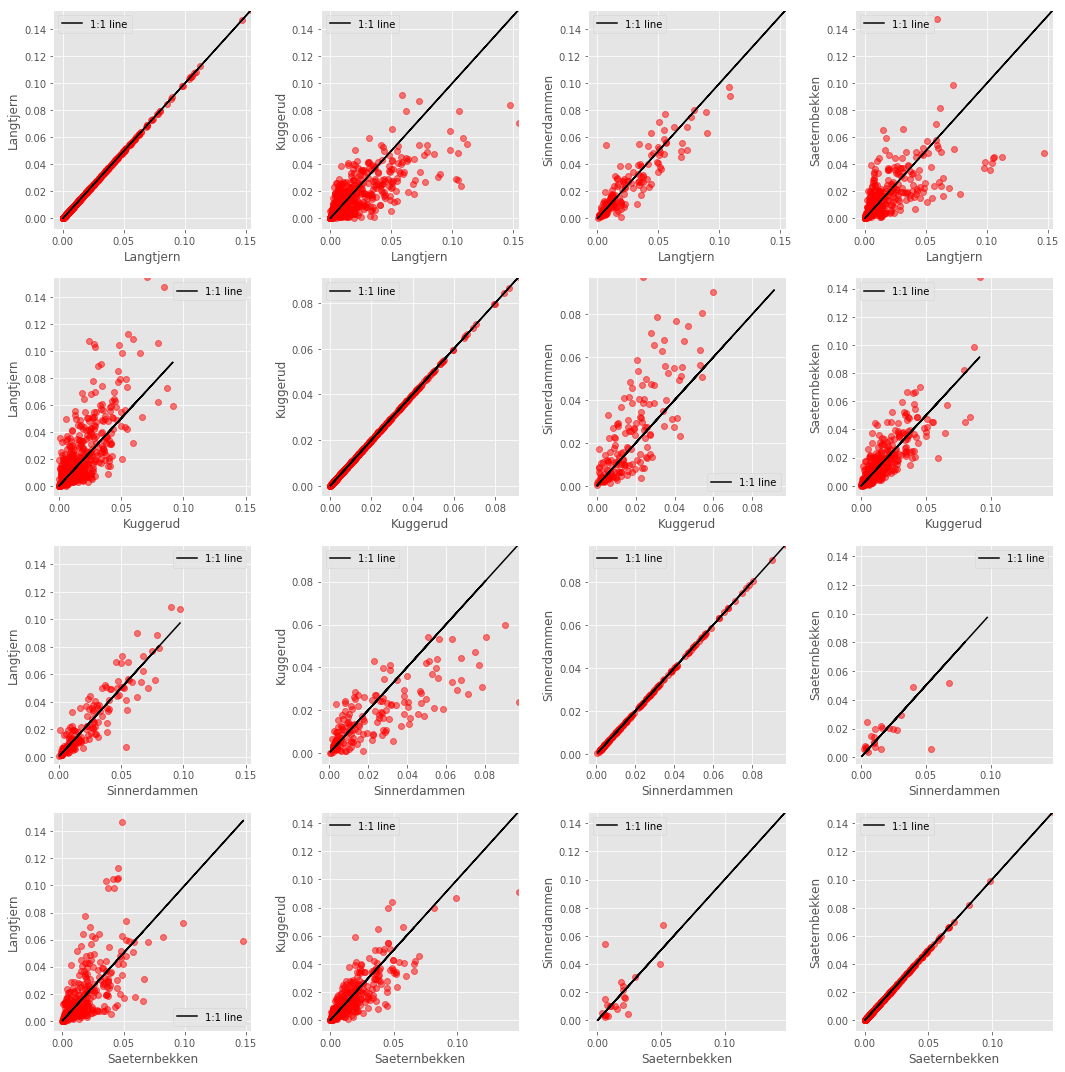

In [5]:
# Convert to monthly averages
df = df.resample('M').mean()

# Consider just "natural" streams for now
df2 = df.copy()
del df2['Fossen']

for col in df2.columns:
     # Normalise areas
    area = stn_df.query('station_name == @col')['nve_area_km2'].values[0]    
    df2[col] = df2[col] / area
    
# Scatterplot matrix    
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))

for xidx, xcol in enumerate(df2.columns):
    for yidx, ycol in enumerate(df2.columns):
        # Data
        axes[xidx, yidx].plot(df2[xcol], df2[ycol], 'ro', alpha=0.5, label='')
        axes[xidx, yidx].plot(df2[xcol], df2[xcol], 'k-', label='1:1 line')
        axes[xidx, yidx].set_xlabel(xcol)
        axes[xidx, yidx].set_ylabel(ycol)
        
        # Axis scaling
        ax_max = max(df2[xcol].max(), df2[ycol].max())
        axes[xidx, yidx].set_xlim(right=ax_max)
        axes[xidx, yidx].set_ylim(top=ax_max)
        
        axes[xidx, yidx].legend(loc='best')        
        
plt.tight_layout()

There is quite a lot of scatter on these plots, but in general the area-normalised monthly flows (i.e. discharge per km<sup>2</sup>) are comparable, which is promising. 

Langtjern and Sinnerdammen have similar flow regimes - both slightly wetter than at Kuggerud. This seems reasonable, since Langtjern and Sinnerdammen are small catchments to the west of Nitelva, whereas Kuggerud is a larger catchment to the east (presumably with lower rainfall). Sæternbekken is broadly comparable to Kuggerud, but according to NVE the quality of the series is poor and the amount of reliable recent data is limited. I will therefore remove this from further analysis.

Langtjern, Sinnerdammen and Kuggerud all have near-complete data records since 2005, so I can use these data to estimate "natural" series for Fossen. Each of the three catchments will give a slightly different estimate for the natural Nitelva flow regime, and the variability in this output should give a rough indication of uncertainty in the area-scaling approach.

**Note:** Because Langtjern and Sinnerdammen are small headwater catchments to the west of Nitelva, we might expect area-scaled time series from these locations to overestimate flows at Fossen. Conversely, Kuggerud is a slightly larger catchment to the east, so area-scaling here is likely to produce underestimates.

In [6]:
# Just catchments of interest
df2 = df.copy()
del df2['Saeternbekken']

# Patch data gaps
df2 = df2.interpolate(kind='linear')

# 2005 to 2018
df2 = df2.truncate(before='2005-01-01', after='2018-12-31')

# Area-scaling
fossen_area = stn_df.query('station_name == "Fossen"')['nve_area_km2'].values[0] 
for col in df2.columns:
    area = stn_df.query('station_name == @col')['nve_area_km2'].values[0] 
    df2[col] = df2[col] * fossen_area / area
    
# Tidy column names
df2.rename({'Fossen':'Fossen_Obs',
            'Langtjern':'Langtjern_Scaled',
            'Kuggerud':'Kuggerud_Scaled',
            'Sinnerdammen':'Sinnerdammen_Scaled',
           },
           inplace=True,
           axis=1)

As an illustration of results, the plot below shows the observed data from Fossen and the three area-scaled series for the years 2016 to 2018. As expected, the series based on Langtjern and Sinnerdammen tend to overestimate flows, while the data scaled from Kuggerud generally yields underestimates. Based on this plot, I cannot see strong evidence for flows at Fossen being impacted by hydromorphological alteration - the curve labelled `'Fossen_Obs` below does not stand out as being particularly unusual compared to the three scaled "natural" series.

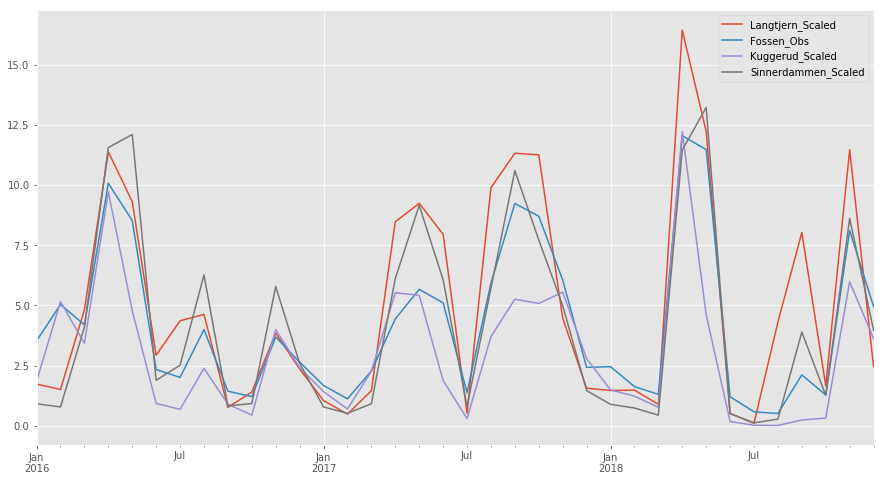

In [7]:
# Plot
df2['2016-01-01':].plot(figsize=(15,8))

## 4. Flow duration curves

[Flow duration curves (FDCs)](https://streamflow.engr.oregonstate.edu/analysis/flow/index.htm) provide a useful way of summarising and comparing flow regimes. They're also used a lot in preliminary site assessments for hydropower development (see e.g. a previous project [here](https://nbviewer.jupyter.org/github/JamesSample/simple_hydropower_model/blob/master/hydropower_notes.ipynb), which used FDCs to assess climate change impacts on hydropower potential). The code below is modified from this previous project.

In [8]:
def select_season(df, season):
    """ Takes a dataframe with a date-time index and selects just the rows
        corresponding to the selected season.
    
    Args:
        df:     Data frame of flow data
        season: 'Spring' - M, A, M
                'Summer' - J, J, A
                'Autumn' - S, O, N
                'Winter' - D, J, F
    
    Returns:
        Dataframe.
    """
    seasons_dict = {'spring':[3, 4, 5],
                    'summer':[6, 7, 8],
                    'autumn':[9, 10, 11],
                    'winter':[1, 2, 12]}
    
    return df[df.index.map(lambda x: x.month in seasons_dict[season.lower()])]

def fdc_from_obs(df, col):
    """ Calculates a Flow Duration Curve (FDC).
    
    Args:
        df:  Dataframe. Flow data
        col: Str. Name of column with flows
    
    Returns:
        Arrays of flows and associated exceedence probabilities.
    """   
    # Just col of interest, dropping NaN
    df2 = df[[col]].dropna()
    
    # Sort
    df2 = df2.sort_values(by=col,
                          ascending=False).reset_index(drop=True)
    
    # Get ranks, where rank 1 = largest
    ranks = np.arange(1, len(df2)+1)
    
    # Get exceedence prob
    ex_prob = 100.*ranks/(len(ranks)+1)
    
    return ex_prob, df2

In [9]:
# Calculate FDCs for each series in each season
data_dict = {}

for col in df2.columns:
    for season in ['Annual', 'Spring', 'Summer', 'Autumn', 'Winter']:
        if season == 'Annual':
            q_df = df2.copy()
        else:
            q_df = select_season(df2.copy(), season)

        # Calculate FDC
        ex_prob, qs = fdc_from_obs(q_df, col)
        
        # Save results
        data_dict[(col, season)] = (ex_prob, qs)

I will plot **annual** and **seasonal** FDCs based on **monthly average flows between 2005 and 2018**. Instead of plotting separate FDCs for the three scaled "natural" timeseries, I will plot the **range** between the minimum and maximum predictions as a shaded pink area, plus the **mean** prediction and a solid red line. The actual FDC based on observed data from Fossen is plotted as a solid black line for comparison.

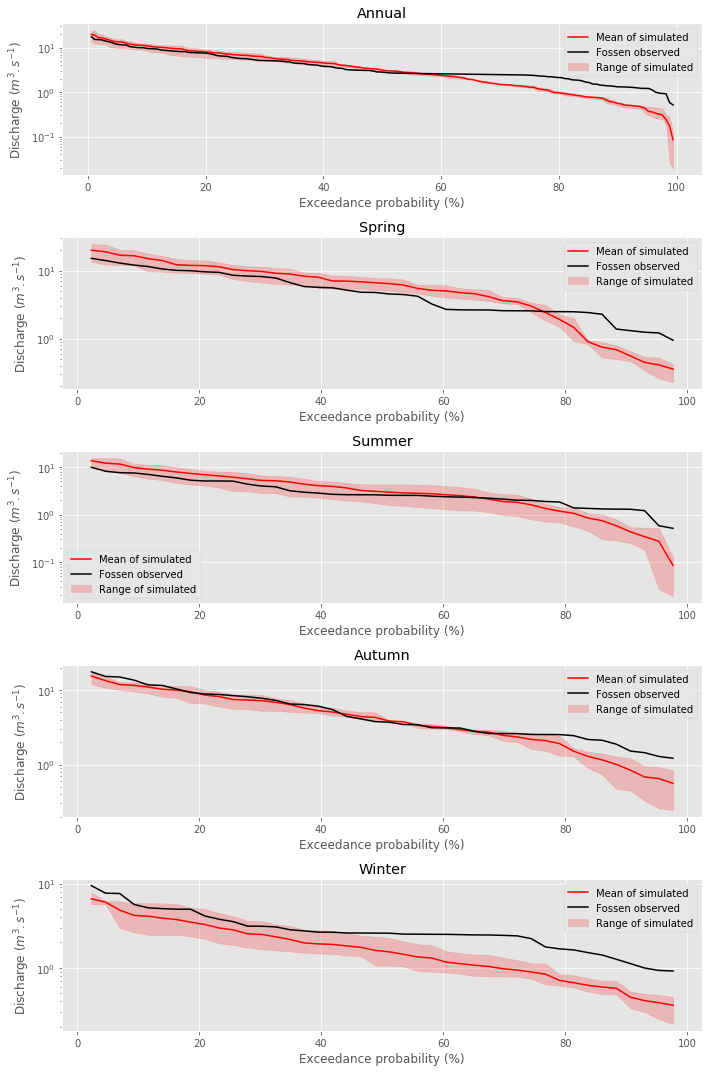

In [10]:
# Plot FDCs
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,15))

for idx, season in enumerate(['Annual', 'Spring', 'Summer', 'Autumn', 'Winter']):
    # Get scaled data
    prob1, qs1 = data_dict[('Langtjern_Scaled', season)]
    prob2, qs2 = data_dict[('Kuggerud_Scaled', season)]
    prob3, qs3 = data_dict[('Sinnerdammen_Scaled', season)]

    assert ((prob1 == prob2).all() and (prob2 == prob3).all())
    
    # Get min, max and mean (plus percentiles, if desired later)
    scaled_df = pd.DataFrame({1:qs1.iloc[:,0].values,
                              2:qs2.iloc[:,0].values,
                              3:qs3.iloc[:,0].values,
                             },
                            index = prob1)
    
    scaled_df = scaled_df.T.describe(percentiles=[0.05, 0.5, 0.95]).T
                                                                     
    # Plot range                                                  
    axes[idx].fill_between(scaled_df.index, 
                           scaled_df['min'].values,
                           scaled_df['max'].values, 
                           alpha=0.2,
                           color='r',
                           label='Range of simulated')
    
    # Plot mean
    axes[idx].plot(scaled_df.index, 
                   scaled_df['mean'].values, 
                   'r-',
                   label='Mean of simulated')

    # Plot observed
    ex_prob, qs = data_dict[('Fossen_Obs', season)]
    axes[idx].plot(ex_prob, qs, 'k-', label='Fossen observed')

    axes[idx].set_yscale('log')
    axes[idx].set_title(season)
    axes[idx].legend(loc='best')
    axes[idx].set_xlabel('Exceedance probability (%)')
    axes[idx].set_ylabel('Discharge ($m^3.s^{-1}$)')
        
plt.tight_layout()

# Save
out_png = r'../pngs/fossen_fdcs.png'
plt.savefig(out_png, dpi=300)

## 5. Summary

### 5.1. Workflow

This notebook presents a simple attempt at estimating natural flows for Fossen on the Nitelva. The method involves identifying "natural" analogue catchments in the surrounding region and scaling flow records from these to match the catchment area at Fossen. The approach makes two key assumptions:

 1. The catchments selected for scaling are "natural" i.e. not affected by hydromorphological alteration or flow abstractions and diversions
 
 2. The catchments have similar hydrological characteristics to Nitelva when considered at monthly time scales i.e. similar climate/weather patterns, soil & land cover properties and hydrological responses
 
**Both of these are big assumptions!** For (1), I have checked that the selected catchments are not obviously modified based on data from [NVE Atlas](https://atlas.nve.no/Html5Viewer/index.html?viewer=nveatlas&layerTheme=null&scale=80000&basemap=&center=271063.78950149193%2C6669407.491612272&layers=3H1NK20Qc%2Bmp3Sp11M0VyC4j0VyC4j1RTtWs05u0nq3BHcOm), but other than this I have no first-hand knowledge of morphological alteration in these areas. For (2), it should be noted that two of the selected catchments (Langtjern and Sinnerdammen) are small compared to Nitelva, and substantial errors are incurred in scaling flows from small headwater catchments (< 10 km<sup>2</sup>) to larger basins such as Fossen (> 200 km<sup>2</sup>). In particular, the presence of large natural lakes in the Fossen watershed will act to buffer hydrological responses. These effects will not be well represented in the scaled series from Langtjern and Sinnerdammen; Kuggerud might be a better analogue in this regard, because it is slightly larger (~ 50 km<sup>2</sup>) and inlcudes several moderately sized lakes. Unfortunately, it has not been possible to find a natural analogue in this region of similar size to Fossen, as all the larger Nordmarka catchments seem to be modified to some extent. A final consideration is that Langtjern and Sinnerdammen have slighlty higher runoff than Nitelva, whereas the values for Kruggerud are slightly lower. I hope that by combining data from all three catchments, the estimates for Nitelva will be broadly plausible.

### 5.2. Results

The FDCs above illustrate differences between the observed flow regime at Fossen (black line) and the estimated "natural" flow regime, calculated from the three analogue catchments (the red line shows the mean of the simulated series; the pink shading shows the range). 

On the **annual** plot, observed high flows at Fossen are broadly the same as expected under natural conditions i.e. the effects of morphological alteration are not obvious at high flows. This is perhaps to be expected, given that the hydropower infrastructure comprises mostly small (~ 300 kW) run-of-river schemes with limited offtake, so at high flows most of the water will probably bypass the hydropower plants anyway. Interestingly, the plot further suggests that **low flows at Fossen are currently higher than might be expected under natural conditions** i.e. the most obvious effects of morphological changes at annual time scales is to **reduce overall flow variability by sustaining low flows**. This is plausible, since the dams at Verksfossen and Sagfossen provide additional water storage, which may sustain flows during dry periods. However, I'm not sure how this fits with observations of stranded fish "drying out" events, as mentioned in the proposal document.

The seasonal FDCs for **spring**, **summer** and **autumn** show a similar pattern to the annual results: within error, high flows at Fossen are more-or-less as expected under natural conditions (i.e. the effects of modification are not obvious), whereas low flows are gererally slightly higher than might be expected, probably due to additional water storage capacity created by the dams.

The FDC for **winter** is slightly different, and implies that observed flows at Fossen are generally higher than would be expected under natural conditions for almost all flows. This may, again, be due to additional storage capacity, but **I don't have much faith in these results**: the natural analogue catchments are small, and winter flows are notoriously difficult to measure accurately due to ice effects etc. I suspect the errors invovled in scaling the winter data to match Fossen are large and should not be trusted. 

### 5.3. Tentative conclusions

 * This workflow is rough and errors involved are large. **Use these results as a guide, but don't interpret them too literally!**
 
 * **Modifications to the natrual flow regime upstream of Fossen do not appear to significantly affect flows downstream**. There is some evidence that **overall flow variability is reduced**, most likely because the **additional storage capacity provided by the dams sustains flows during dry periods, thereby reducing the frequency of natural drought events**
 
 * These results seem plausible, but the effect sizes are small. **Given the data available and the erros in the workflow, I don't think we can unambiguously demonstrate significant effects from hydropower on the natural flow regime**
 
 * All the calculations here consider the flow regime at Fossen, several kilometres downstream from the Sagfossen dam. The three hydropower schemes under consideration in this project are run-of-river installations, with only small impoundments. In these schemes, water is diverted into a penstock for power generation, then returned to the main channel a short distance downstream. Since the impoundments at the dams are small, such schemes are not expected to dramatically alter flow regimes downstream of the outflows. They do, however, significantly affect flow conditions in the river channel next to the penstock i.e. immediately downstream of each hydrpower plant, between the intake and the outflow. These reaches may be significantly affected e.g. by becoming more suceptible to "drying out" events. I'm guessing these areas are where fish strandings have been observed in the past? Note that the calculations here say nothing about the extent of impacts in these depleted reaches; simulating these would require detailed operational data from each hydropower plant